In [100]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from classifier import train_one_vs_all, predict_one_vs_all
from logistic_regression import logistic, nll_cost_function, gradient_descent

In [101]:
np_data = pd.read_csv('BLCA.csv',keep_default_na=False, sep=';',header=None, encoding = "utf-8").values

# age 
age = np_data[:,2].astype(int)

# gender
gender = np_data[:,3]
gender = np.array([l == 'FEMALE' for l in gender]).astype('int') #0 man, 1 woman

# ajcc_pathologic_tumor_stage
tumor_stage = np_data[:,4]
tumor_stage = np.where(tumor_stage=="Stage I", 0, tumor_stage)
tumor_stage = np.where(tumor_stage=="Stage II", 1, tumor_stage)
tumor_stage = np.where(tumor_stage=="Stage III", 2, tumor_stage)
tumor_stage = np.where(tumor_stage=="Stage IV", 3, tumor_stage)

# histological_type
histological_type = np_data[:,5] # ignore, they are all the same

# histological_grade
histological_grade = np_data[:,6] # ignore, they are all the same

# initial_pathologic_dx_year
initial_pathologic_dx_year = np_data[:,7].astype(int)

# vital_status
vital_status = np_data[:,8]
vital_status = np.array([l == 'Alive' for l in vital_status]).astype('int') #0 Dead, 1 Alive

# tumor_status
tumor_status = np_data[:,9] 
tumor_status = np.array([l == 'WITH TUMOR' for l in tumor_status]).astype('int') #0 no tum, 1 with tum

# death_days_to
death_days_to = np_data[:, 10] 

# new_tumor_event_type
new_tumor_event_type = np_data[:,11] # N/A - 0, other - 1
new_tumor_event_type = np.array([l != '#N/A' for l in new_tumor_event_type]).astype('int') #0 no tum, 1 with tum

# new_tumor_event_site
new_tumor_event_site = np_data[:,12]
new_tumor_event_site = np.array([l != '#N/A' for l in new_tumor_event_site]).astype('int') #0 no tum, 1 with tum

#new_tumor_event_site_other

#new_tumor_event_dx_days_to
new_tumor_event_dx_days_to = np_data[:,14]
new_tumor_event_dx_days_to = np.where(new_tumor_event_dx_days_to=="#N/A", 0 , new_tumor_event_dx_days_to).astype(int)


#treatment_outcome_first_course
outcome = np_data[:,15];
outcome = np.where(outcome=="Complete Remission/Response", 0, outcome)
outcome = np.where(outcome=="Partial Remission/Response", 3, outcome)
outcome = np.where(outcome=="Progressive Disease", 2, outcome)
outcome = np.where(outcome=="Stable Disease", 1, outcome)

m = np_data.shape[0]
X = np.stack([np.ones(m), age, gender, tumor_stage, initial_pathologic_dx_year, tumor_status, new_tumor_event_type,new_tumor_event_site, new_tumor_event_dx_days_to], axis=1).astype(int)
n = X.shape[1]


In [103]:
theta = np.ones(n)
iters = 200
y = vital_status

theta, J = gradient_descent(X, y, theta, 0.0000001, iters)
# print(J[-20:-1])

y_predict = np.zeros(len(y))
correct_pred = 0
result = logistic(np.dot(X,theta))
y_predict =  np.where(result < 0.5, 0, result)
y_predict =  np.where(y_predict >= 0.5, 1, y_predict)

for i in range(len(y)):
    if  y_predict[i] == y[i]:
        correct_pred+=1

print("accuracy:", np.around(correct_pred/len(y)*100,2),"%")

accuracy: 58.18 %


In [104]:
# choose only dead ones 
dead = np.nonzero(vital_status == 0)[0] # indices of dead people
np.random.shuffle(dead)
y = death_days_to[dead].astype('int') # get all y's
X = np.stack([np.ones(m), age, gender, tumor_stage, initial_pathologic_dx_year, tumor_status, new_tumor_event_type,new_tumor_event_site, new_tumor_event_dx_days_to], axis=1).astype(int)
X = X[dead, :]

numTrain    = 107
numTest     = 26

train = np.arange(numTrain)
test  = numTrain + np.arange(numTest)

X_train = X[train,:]
y_train = y[train]

X_test  = X[test,:]
y_test  = y[test]



In [105]:
# regression
def gradient_descent( X, y, alpha, iters, theta=None ):

    m,n = X.shape
    
    if theta is None:
        theta = np.ones(n)
    
    J_history = np.ones(iters)

    for i in range(0, iters):
        
        theta = theta - np.dot(alpha*X.T, np.dot(X, theta) - y)
        J_history[i] = cost_function(X, y, theta)
    
    return theta, J_history

def cost_function(X, y, theta):  
    cost = 0
    diff = (np.dot(X,theta)-y).T
    diff = np.where(abs(diff) < 30, 0, diff)
    cost = 0.5*np.dot(diff, diff)
    return cost

def normalize( M ):
    norm_M = M.copy()
    mean = np.mean(M[:, 1:].copy(), axis = 0)
    std = np.array(np.std(M[:, 1:].copy(), axis = 0))
    norm_M[:,1:] = np.divide(np.subtract(norm_M[:,1:], mean), std)
    return norm_M

In [106]:
theta_vec_equations, cost = gradient_descent(normalize(X_train), y_train, 0.005, 40000)
print ("Cost function: %.2f" % cost[-1])
print(cost)

Cost function: 6260606.56
[9614664.6000625  8216562.6741089  7568788.00528833 ... 6260606.55859111
 6260606.55859111 6260606.55859111]


In [107]:
'''
    Classification by the outcome
    
''' 

X = np.stack([np.ones(m), age, gender, tumor_stage, initial_pathologic_dx_year, tumor_status, new_tumor_event_type,new_tumor_event_site, new_tumor_event_dx_days_to], axis=1).astype(int)
y = outcome
numClasses = 3
numTrain = 99 
numTest = 24

class_1 = np.nonzero(y == 0)[0]   
class_2 = np.nonzero(y == 1)[0]   
class_3 = np.nonzero(y == 2)[0]   
class_4 = np.nonzero(y == 3)[0]   # ignoring this one
nlen = len(class_2)
subset = np.concatenate([class_1[0:len(class_2)], class_2, class_3])
np.random.shuffle(subset)
X = X[subset,:]
y = y[subset]

# Split into test and train
train = np.arange(numTrain)
test  = numTrain + np.arange(numTest)

X_train = X[train,:]
y_train = y[train]

X_test  = X[test,:]
y_test  = y[test]



In [113]:
lambda_val = 100
weight_vectors, intercepts = train_one_vs_all(X_train, y_train, 3, lambda_val)
pred_train = predict_one_vs_all(X_train, weight_vectors, intercepts)
pred_test  = predict_one_vs_all(X_test,  weight_vectors, intercepts)
print("Training Set Accuracy: %f" % (np.mean(pred_train == y_train) * 100))
print("    Test Set Accuracy: %f" % (np.mean( pred_test == y_test) * 100))

lambda_vals = 10.0 ** np.linspace(-5,5,11)
num_classes = 10

test_acc = np.zeros(lambda_vals.size)
train_acc = np.zeros(lambda_vals.size)

for i in range(lambda_vals.size): 
    weight_vectors, intercepts = train_one_vs_all(X_train, y_train, 3, lambda_vals[i])
    pred_train = predict_one_vs_all(X_train, weight_vectors, intercepts)
    pred_test  = predict_one_vs_all(X_test,  weight_vectors, intercepts)

    print("Lambda: %f" % lambda_vals[i], "Training Set Accuracy: %f" % (np.mean(pred_train == y_train) * 100))
    print("Lambda: %f" %  lambda_vals[i] , "Test Set Accuracy: %f" % (np.mean( pred_test == y_test) * 100))
    train_acc[i] = np.mean(pred_train == y_train) * 100
    test_acc[i] = np.mean( pred_test == y_test) * 100
    
    

Training Set Accuracy: 58.585859
    Test Set Accuracy: 54.166667
Lambda: 0.000010 Training Set Accuracy: 77.777778
Lambda: 0.000010 Test Set Accuracy: 66.666667
Lambda: 0.000100 Training Set Accuracy: 75.757576
Lambda: 0.000100 Test Set Accuracy: 66.666667
Lambda: 0.001000 Training Set Accuracy: 77.777778
Lambda: 0.001000 Test Set Accuracy: 66.666667
Lambda: 0.010000 Training Set Accuracy: 75.757576
Lambda: 0.010000 Test Set Accuracy: 66.666667
Lambda: 0.100000 Training Set Accuracy: 75.757576
Lambda: 0.100000 Test Set Accuracy: 66.666667
Lambda: 1.000000 Training Set Accuracy: 76.767677
Lambda: 1.000000 Test Set Accuracy: 62.500000
Lambda: 10.000000 Training Set Accuracy: 72.727273
Lambda: 10.000000 Test Set Accuracy: 66.666667
Lambda: 100.000000 Training Set Accuracy: 58.585859
Lambda: 100.000000 Test Set Accuracy: 54.166667
Lambda: 1000.000000 Training Set Accuracy: 50.505051
Lambda: 1000.000000 Test Set Accuracy: 58.333333
Lambda: 10000.000000 Training Set Accuracy: 50.505051
Lamb

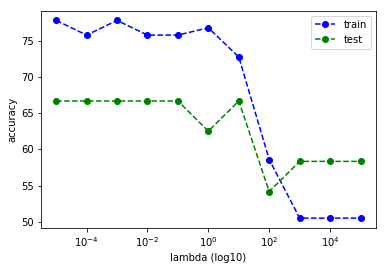

In [114]:
plt.xlabel('lambda (log10)')
plt.ylabel('accuracy')
plt.xscale('log')
plt.plot(lambda_vals, train_acc, 'bo', linestyle='dashed')
plt.plot(lambda_vals, test_acc, 'go', linestyle='dashed')
plt.legend(('train', 'test')) #if you use this legend, make sure you plot the training data first and then the test data
plt.show()
